# [3주차] 기본과제 - DistilBERT로 뉴스 기사 분류 모델 학습하기

💡 이번 과제에서는 pre-trained 된 DistilBERT를 뉴스 기사 분류 문제에 적용합니다.


#### 🔸 pip install library

In [ ]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses datasets

### 🔸 load tokenizer

DistilBERT 모델용 tokenizer를 로드합니다.

🔍 이미 pre-training 단계에서 해당 tokenizer를 사용한 데이터로 학습되었기 때문에 같은 tokenizer를 사용해야합니다.

In [ ]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm import tqdm

tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'distilbert-base-uncased')

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### 🔸 dataset summary

#### 📰 AG_News dataset
뉴스 기사 제목과 내용을 기반으로 텍스트 분류를 학습하기 위한 데이터 셋




* load dataset
* collate_fn

In [ ]:
train_ds = load_dataset("fancyzhx/ag_news", split="train[:5%]")
test_ds = load_dataset("fancyzhx/ag_news", split="test[:5%]")

##### 📂 데이터 구성 확인

* 데이터 길이 (5% 기준)
 * train : 6000
 * test : 380

* 데이터 예시
```json
{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'label': 2}
```

* 🏷️ label class (4개)

|index|category|
|--|--|
|1|World|
|2|Sports|
|3|Business|
|4|Sci/Tech|

In [ ]:
print(f"train dataset length : {len(train_ds)}")
print(f"test dataset length : {len(test_ds)}")

train dataset length : 6000
test dataset length : 380


In [ ]:
print(train_ds[0])

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'label': 2}


In [ ]:
train_ds.features["label"].names

['World', 'Sports', 'Business', 'Sci/Tech']

In [ ]:
label_map = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Sci/Tech"
}

##### 📂 dataset 전처리

* collate_fn
 * truncation 삭제 : 전체 news 데이터를 보고 classify 하기 위함

In [ ]:
# 데이터를 배치로 묶기 위한 함수 정의
def collate_fn(batch):
    texts, labels = [], []  # 입력 문장들과 라벨들을 저장할 리스트

    # 배치 내 각 샘플에 대해 text와 label 추출
    for row in batch:
        labels.append(row['label'])
        texts.append(row['text'])

    # tokenizer로 텍스트를 토큰화하고, 최대 길이로 패딩 및 자르기
    # tokenizer는 사전에 정의되어 있어야 함 (예: tokenizer = AutoTokenizer.from_pretrained(...))
    texts = torch.LongTensor(
        tokenizer(texts, padding=True).input_ids
    )

    # 라벨 리스트를 LongTensor로 변환
    labels = torch.LongTensor(labels)

    # 모델 학습에 필요한 입력 (토큰화된 문장들)과 정답 라벨 반환
    return texts, labels


In [ ]:
def make_data_loader(train_ds, test_ds, batch_size):
    train_loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn
    )

    test_loader = DataLoader(
        test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn
    )
    return train_loader, test_loader

train_loader, test_loader = make_data_loader(train_ds, test_ds, 64)

### 🔸 load pre-trained DistilBERT



In [ ]:
#DistilBERT 모델을 PyTorch Hub에서 로드 후 model 출력
pre_trained_model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')
pre_trained_model

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

##### 🔍 DistilBERT model summary

###### embeddings
* word_embeddings
 * vocab_size (tokenizer에서 지원하는 vocab 길이) : 30522
 * embed_dim : 768
* position_embeddings
 * 위치정보 최대 512 토큰
* LayerNorm 사용
* dropout 비율 0.1

###### transformer
* 총 6개의 transformer block 으로 구성됨
 * Self Attention
 * sa layer norm
 * Feed Forward network
 * output layer norm

##### 🔍 positional encoding

```
(position_embeddings): Embedding(512, 768)
```

positional embedding vector가 512개만 준비되어 있다.
따라서 우리 데이터가 512 token이 넘는지 확인해보고 넘어가려고 한다.

In [ ]:
from datasets import concatenate_datasets

# train_ds와 test_ds 합치기
all_ds = concatenate_datasets([train_ds, test_ds])

# 토큰 길이 측정
max_len = 0
long_samples = []

for i, sample in enumerate(all_ds):
    tokens = tokenizer(sample['text'], truncation=False, return_tensors="pt")
    input_len = tokens['input_ids'].shape[1]

    if input_len > max_len:
        max_len = input_len

    if input_len > 512:
        long_samples.append((i, input_len))

print(f"최대 토큰 길이: {max_len}")
print(f"512 토큰을 넘는 샘플 수: {len(long_samples)}")


최대 토큰 길이: 342
512 토큰을 넘는 샘플 수: 0


512 토큰 넘는 데이터가 있으면 따로 처리를 해줘야할 것 같은데, 다행히 우리 데이터셋에는 512를 넘는 데이터는 없다.

### 🔸 TextClassifier

binary classification이 아닌 label이 4개 종류이므로 그 구조에 맞게 변경 해준다.
* loss_fn : CrossEntropyLoss
* TextClassifier 출력 차원 조절 : 4

In [ ]:
from torch import nn

# 텍스트 분류 모델 정의 (DistilBERT + Linear layer(분류기))
class TextClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = pre_trained_model

        # [CLS] 토큰 분류기 정의
        self.classifier = nn.Linear(768, 4)

    def forward(self, x):
        x = self.encoder(x)['last_hidden_state']
        x = self.classifier(x[:, 0])

        return x

model = TextClassifier()

In [ ]:
model

TextClassifier(
  (encoder): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Line

마지막에 classifier 부분이 생긴 걸 확인할 수 있습니다.

##### freeze pre-trained model

마지막 classifier layer를 제외한 나머지 부분을 freeze 합니다.

* 특정 부분만 학습
 * pre-trained model은 이미 언어를 잘 학습한 상태
 * classifier 만 학습 시킨다.
* 학습 속도 단축
 * 업데이트 대상 파라미터가 줄어들기 때문에 속도 빨라짐
* 오버 피팅 방지


In [ ]:
for param in model.encoder.parameters():
  param.requires_grad = False

### 🔸 model 학습
* accuracy method 수정

In [ ]:
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
model = model.to('cuda')  # 모델을 GPU로 이동
loss_fn = nn.CrossEntropyLoss()  # 분류용 손실 함수

# 학습 설정 (hyperparam)
lr = 0.001
optimizer = Adam(model.parameters(), lr=lr)
n_epochs = 5

In [ ]:
def accuracy(model, dataloader, is_need_raw_data):
    cnt = 0
    acc = 0
    raw_data = []

    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        preds = model(inputs)
        preds = torch.argmax(preds, dim=-1)

        cnt += labels.shape[0]
        acc += (labels == preds).sum().item()

        if is_need_raw_data: # 마지막 에폭인 경우에만 수행 (time issue)
            for i in range(inputs.size(0)):
                decoded_text = tokenizer.decode(inputs[i], skip_special_tokens=True)
                true_label = label_map[labels[i].item()]
                pred_label = label_map[preds[i].item()]
                is_correct = (labels[i] == preds[i]).item()  # True → 1, False → 0
                raw_data.append({
                    "text": decoded_text,
                    "true_label": true_label,
                    "pred_label": pred_label,
                    "is_correct": is_correct
                })


    accuracy_score = acc/cnt

    return accuracy_score, raw_data

In [ ]:
def finetune_model(model, train_loader, test_loader, n_epochs, loss_fn):
    train_loss_list = []
    train_acc_list = []
    test_acc_list = []

    for epoch in range(n_epochs):
        total_loss = 0.
        model.train()  # 학습 모드 설정

        for data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}"):
            model.zero_grad()  # 이전 gradient 초기화

            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')  # GPU 이동 및 float 변환

            preds = model(inputs)

            loss = loss_fn(preds, labels)  # 손실 계산
            loss.backward()  # 역전파
            optimizer.step()  # 파라미터 업데이트

            total_loss += loss.item()  # loss 누적

        with torch.no_grad():
            model.eval()
            is_need_raw_data = 1 if epoch == n_epochs - 1 else 0 # 마지막 epoch인 경우 raw_data를 보고 싶어서 flag 추가
            train_acc, train_fail_case = accuracy(model, train_loader, is_need_raw_data)
            test_acc, test_fail_case = accuracy(model, test_loader, is_need_raw_data)

        print(f"Epoch {epoch:3d} | Train Loss: {total_loss} | Train Acc: {train_acc: .3f} | Test Acc: {test_acc: .3f}")
        train_loss_list.append(total_loss)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
    return train_loss_list, train_acc_list, test_acc_list, train_fail_case, test_fail_case

In [ ]:
total_loss, train_acc, test_acc, train_raw, test_raw = finetune_model(model, train_loader, test_loader, n_epochs, loss_fn)

Epoch 1/5: 100%|██████████| 94/94 [00:24<00:00,  3.85it/s]


Epoch   0 | Train Loss: 98.87259531021118 | Train Acc:  0.820 | Test Acc:  0.842


Epoch 2/5: 100%|██████████| 94/94 [00:25<00:00,  3.67it/s]


Epoch   1 | Train Loss: 68.78720426559448 | Train Acc:  0.803 | Test Acc:  0.839


Epoch 3/5: 100%|██████████| 94/94 [00:25<00:00,  3.75it/s]


Epoch   2 | Train Loss: 58.952987253665924 | Train Acc:  0.833 | Test Acc:  0.829


Epoch 4/5: 100%|██████████| 94/94 [00:25<00:00,  3.69it/s]


Epoch   3 | Train Loss: 54.27644860744476 | Train Acc:  0.836 | Test Acc:  0.832


Epoch 5/5: 100%|██████████| 94/94 [00:25<00:00,  3.64it/s]


Epoch   4 | Train Loss: 51.3956001996994 | Train Acc:  0.843 | Test Acc:  0.845


### 🔸학습 결과 분석
* 학습 result 확인
* fail 원인 분석

#### 📊 데이터 plot 관련 method

1. loss_plot : epoch당 loss 출력
```python
def loss_plot(loss_list, title="Loss over Epochs"):
```
2. compare_acc_plot : 2개의 acc를 비교하는 plot
```python
def compare_acc_plot(acc1, acc2, label1, label2, title_suffix=""):
```
3. label_acc_plot : label당 정확도 비교 plot
```python
def label_acc_plot(df, label_col="true_label", correct_col="is_correct", title="Per-Class Accuracy"):
```


In [ ]:
def loss_plot(loss_list, title="Loss over Epochs"):
    epochs = range(1, len(loss_list)+1)

    plt.figure()
    plt.plot(epochs, loss_list, marker='o')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

In [ ]:
def compare_acc_plot(acc1, acc2, label1, label2, title_suffix=""):
    epochs = range(1, len(acc1) + 1)

    cut_acc2 = acc2[:len(acc1)]
    plt.figure()
    plt.plot(epochs, acc1, label=label1, marker='o')
    plt.plot(epochs, cut_acc2, label=label2, marker='s')
    plt.title(f"Accuracy over Epochs {title_suffix}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def label_acc_plot(df, label_col="true_label", correct_col="is_correct", title="Per-Class Accuracy"):
       # Group by label → 평균 정확도 계산
    class_accuracy = df.groupby(label_col)[correct_col].mean().sort_values(ascending=False)

    # 시각화
    plt.figure()
    class_accuracy.plot(kind='bar')
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1.0)
    plt.grid(axis='y')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#### 결과 데이터 확인
1. loss는 점점 줄어듬 > 제대로 학습이 되는 걸 알 수 있다.
2. acc 우상향 > 오르고 내리지만 전체적으론 우상향 했다.
3. label 별 accuracy > business label에서의 정확도가 다른 label일 때보다 낮음을 확인할 수 있다.

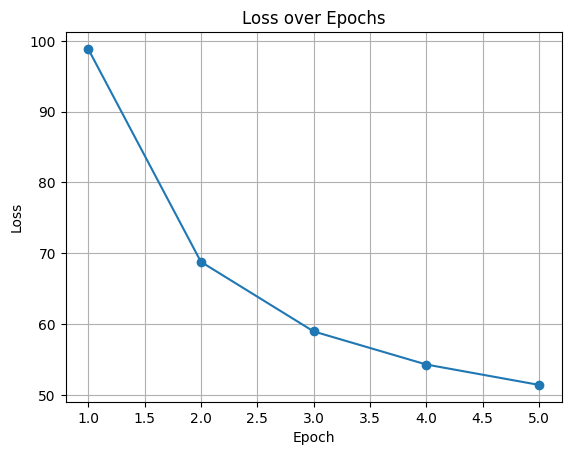

In [ ]:
loss_plot(total_loss)

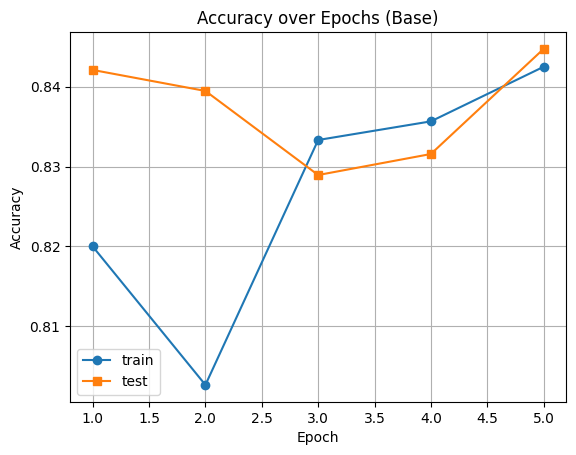

In [ ]:
compare_acc_plot(train_acc, test_acc, 'train', 'test', title_suffix="(Base)")

In [ ]:
import pandas as pd

train_df = pd.DataFrame(train_raw)
test_df = pd.DataFrame(test_raw)

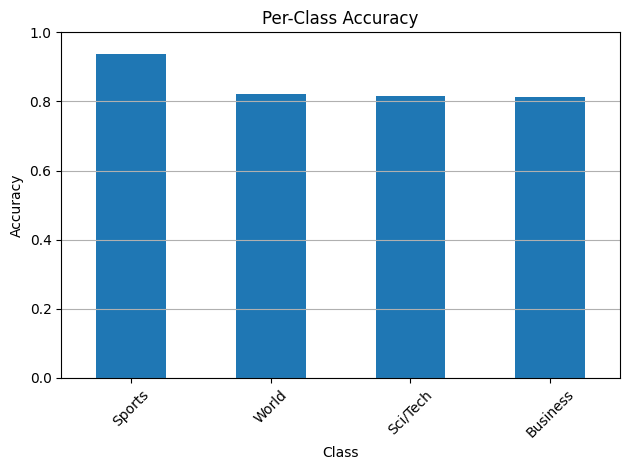

In [ ]:
label_acc_plot(train_df)

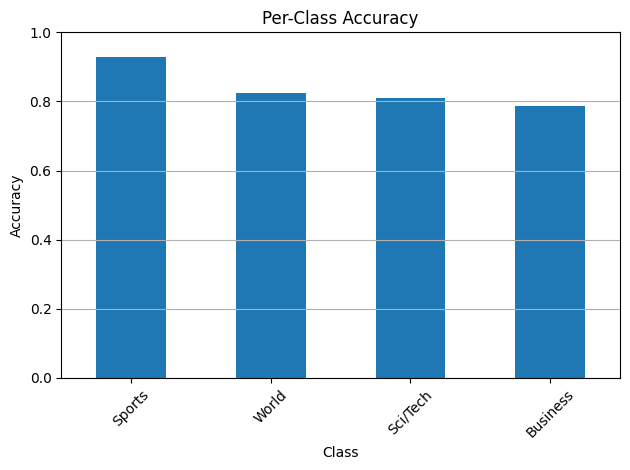

In [ ]:
label_acc_plot(test_df)

전체적으로 Business keyword에 대한 acc가 낮은 걸 볼 수 있음.

#### 🔠 Raw data 확인
테스트 데이터를 분석

In [ ]:
business_errors = test_df[(test_df["true_label"] == "Business") & (test_df["is_correct"] == 0)]
business_errors.to_csv('./test_result.csv', encoding='utf-8-sig')

데이터를 확인해보는데 애매한 데이터들이 많아보임..

|text|label|pred|
|--|--|--|
|대체 에너지에 투자할 준비가 되셨나요? 유가가 오르면 대체 에너지에 대한 대중의 관심도 높아지는 경우가 많다는 사실을 다시 생각해 보십시오. 그러나 그 논리는 분명히 월스트리트를 벗어나고 있는 것 같습니다.|Business|Sci/Tech|

그래도 특수문자 같은 것들이 많아서 이거부터 전처리를 다시 해보려고 한다.

#### 🧪 실험 1 - clean text, weight_decay
* clean text
```json
{'text': "What's in a Name? Well, Matt Is Sexier Than Paul (Reuters) Reuters - As Shakespeare said, a rose by any other\\name would smell as sweet. Right?",
 'label': 3,
 'cleaned_text': "what's in a name? well, matt is sexier than paul reuters reuters as shakespeare said, a rose by any othername would smell as sweet. right?"}
```
* 더 많은 train_data
```
all_train_ds = load_dataset("fancyzhx/ag_news", split="train[:20%]")
```
* weight_decay 적용

In [ ]:
import re

def clean_text(text):
    text = text.lower()  # 소문자 통일
    text = re.sub(r'\s+', ' ', text)  # 여러 공백 → 하나
    text = re.sub(r'\[[^\]]*\]', '', text)  # 괄호 내용 제거 (예: [사진])
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # URL 제거
    text = re.sub(r'[^a-z0-9.,!?\'\" ]+', '', text)  # 특수문자 제거 (필요시 조절)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [ ]:
# 데이터를 배치로 묶기 위한 함수 정의
def clean_collate_fn(batch):
    texts, labels = [], []  # 입력 문장들과 라벨들을 저장할 리스트

    # 배치 내 각 샘플에 대해 text와 label 추출
    for row in batch:
        labels.append(row['label'])
        texts.append(row['cleaned_text'])

    # tokenizer로 텍스트를 토큰화하고, 최대 길이로 패딩 및 자르기
    # tokenizer는 사전에 정의되어 있어야 함 (예: tokenizer = AutoTokenizer.from_pretrained(...))
    texts = torch.LongTensor(
        tokenizer(texts, padding=True).input_ids
    )

    # 라벨 리스트를 LongTensor로 변환
    labels = torch.LongTensor(labels)

    # 모델 학습에 필요한 입력 (토큰화된 문장들)과 정답 라벨 반환
    return texts, labels


In [ ]:
all_train_ds = load_dataset("fancyzhx/ag_news", split="train[:20%]")

def preprocess(example):
    return {"cleaned_text": clean_text(example["text"])}

clean_train_ds = all_train_ds.map(preprocess)
clean_test_ds = test_ds.map(preprocess)

train_loader_2 = DataLoader(
    clean_train_ds, batch_size=64, shuffle=True, collate_fn=clean_collate_fn
)

test_loader_2 = DataLoader(
    clean_test_ds, batch_size=64, shuffle=False, collate_fn=clean_collate_fn
)

In [ ]:
clean_text_model = TextClassifier()

for param in clean_text_model.encoder.parameters():
  param.requires_grad = False

clean_text_model = clean_text_model.to('cuda')  # 모델을 GPU로 이동
loss_fn = nn.CrossEntropyLoss()  # 분류용 손실 함수

# 학습 설정 (hyperparam)
lr = 0.001
optimizer = Adam(clean_text_model.parameters(), lr=lr, weight_decay=0.01)
clean_n_epochs = 3 # 데이터가 4배가 되어 epoch 소폭 수정

total_loss_2, train_acc_2, test_acc_2, train_raw_2, test_raw_2 = finetune_model(clean_text_model, train_loader_2, test_loader_2, clean_n_epochs, loss_fn)

Epoch 1/3: 100%|██████████| 375/375 [01:14<00:00,  5.06it/s]


Epoch   0 | Train Loss: 257.6385267674923 | Train Acc:  0.850 | Test Acc:  0.847


Epoch 2/3: 100%|██████████| 375/375 [01:13<00:00,  5.11it/s]


Epoch   1 | Train Loss: 187.18878376483917 | Train Acc:  0.853 | Test Acc:  0.850


Epoch 3/3: 100%|██████████| 375/375 [01:14<00:00,  5.04it/s]


Epoch   2 | Train Loss: 181.92113111913204 | Train Acc:  0.860 | Test Acc:  0.855


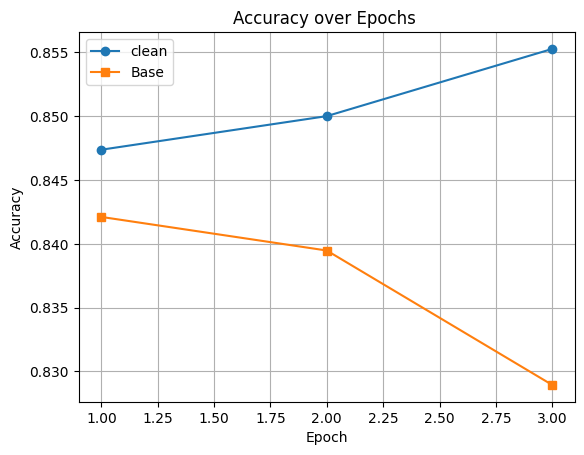

In [ ]:
compare_acc_plot(test_acc_2, test_acc, "clean", "Base")

성능이 더 좋아지는 걸 확인할 수 있다.

#### 🧪 실험 2 - business augmentation

여전히 label별 acc를 확인하면 business가 성능이 좋지 않은 걸 확인할 수 있다.

In [ ]:
test_df_2 = pd.DataFrame(test_raw_2)

In [ ]:
test_df_2.groupby("true_label")["is_correct"].mean()

,is_correct
true_label,
Business,0.757143
Sci/Tech,0.860000
Sports,0.938053
World,0.824742


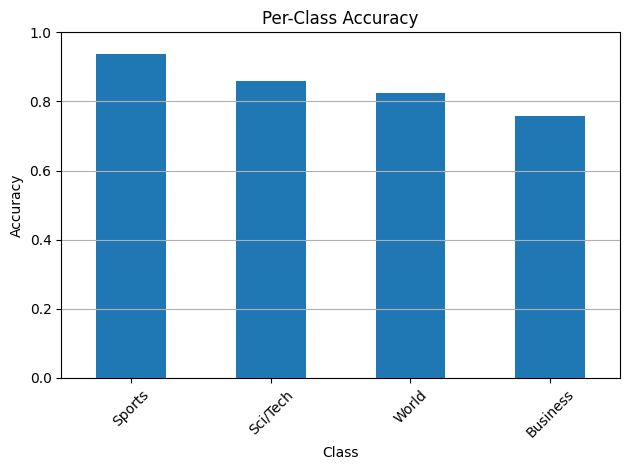

In [ ]:
label_acc_plot(test_df_2)

In [ ]:
label_counts = Counter(all_train_ds["label"])

readable_counts = {label_map[k]: v for k, v in label_counts.items()}
print(readable_counts)

{'Business': 5601, 'Sci/Tech': 6348, 'Sports': 5856, 'World': 6195}


sport는 다른 label에 공통된 점이 적어서 데이터가 적지만 잘 분류되는 것 같다.
근데 business는 world 나 sci/tech와 비슷한 경향이 있는 것 같다. business 데이터만 추가로 더 넣어볼까

📌 business train data만 보강하면 어떻게 될까

In [ ]:
full_ds = load_dataset("fancyzhx/ag_news", split="train")
business_all = full_ds.filter(lambda x:x['label']==2)

n = len(business_all)

start = int(0.95 * n)
extra_business = business_all.select(range(start, n))

print(f"extra business data count is {len(extra_business)}")

augmented_train = concatenate_datasets([all_train_ds, extra_business]).shuffle(seed=42)

extra business data count is 1500


In [ ]:
label_counts = Counter(augmented_train["label"])

readable_counts = {label_map[k]: v for k, v in label_counts.items()}
print(readable_counts)

{'World': 6195, 'Business': 7101, 'Sports': 5856, 'Sci/Tech': 6348}


business data만 1500개 더 보강하였다.

In [ ]:
def preprocess(example):
    return {"cleaned_text": clean_text(example["text"])}

augmentation_train_ds = augmented_train.map(preprocess)
augmentation_test_ds = test_ds.map(preprocess)

train_loader_3 = DataLoader(
    augmentation_train_ds, batch_size=64, shuffle=True, collate_fn=clean_collate_fn
)

test_loader_3 = DataLoader(
    augmentation_test_ds, batch_size=64, shuffle=False, collate_fn=clean_collate_fn
)

In [ ]:
augmentation_text_model = TextClassifier()

for param in augmentation_text_model.encoder.parameters():
  param.requires_grad = False

augmentation_text_model = augmentation_text_model.to('cuda')  # 모델을 GPU로 이동
loss_fn = nn.CrossEntropyLoss()  # 분류용 손실 함수

# 학습 설정 (hyperparam)
lr = 0.001
optimizer = Adam(augmentation_text_model.parameters(), lr=lr, weight_decay=0.01)
clean_n_epochs = 3 # 데이터가 4배가 되어 epoch 소폭 수정

total_loss_3, train_acc_3, test_acc_3, train_raw_3, test_raw_3 = finetune_model(augmentation_text_model, train_loader_3, test_loader_3, clean_n_epochs)

Epoch 1/3: 100%|██████████| 399/399 [01:17<00:00,  5.14it/s]


Epoch   0 | Train Loss: 273.8576321899891 | Train Acc:  0.850 | Test Acc:  0.845


Epoch 2/3: 100%|██████████| 399/399 [01:18<00:00,  5.09it/s]


Epoch   1 | Train Loss: 199.8707830309868 | Train Acc:  0.857 | Test Acc:  0.858


Epoch 3/3: 100%|██████████| 399/399 [01:19<00:00,  5.04it/s]


Epoch   2 | Train Loss: 193.1290901005268 | Train Acc:  0.853 | Test Acc:  0.855


In [ ]:
test_df_3 = pd.DataFrame(test_raw_3)
test_df_3.groupby("true_label")["is_correct"].mean()

,is_correct
true_label,
Business,0.857143
Sci/Tech,0.780000
Sports,0.938053
World,0.835052


##### 실험 결과

|Class	|Before	|After	|변화량 (Δ)|
|--|--|--|--|
|Business|0.7571|	0.8571	|+0.1000 ✅|
|Sci/Tech|	0.8600|	0.7800	|−0.0800 ❌|
|Sports|	0.9381|	0.9381	|+0.0000 🟰|
|World|	0.8247	|0.8351|	+0.0103 ⬆️|


🧠 분석
1. Business 개선
 business 데이터 추가는 성능에 영향을 줌
2. Sci/Tech 성능 하락
 sci/tech와 business를 헷갈려하는 경향이 보임
3. World 약간 상승 Sport 그대로
 business 데이터를 추가한건 두 label에는 거의 영향 없음

> 결론적으로 business와 sci/Tech를 모델이 헷갈려하는 것으로 생각됨


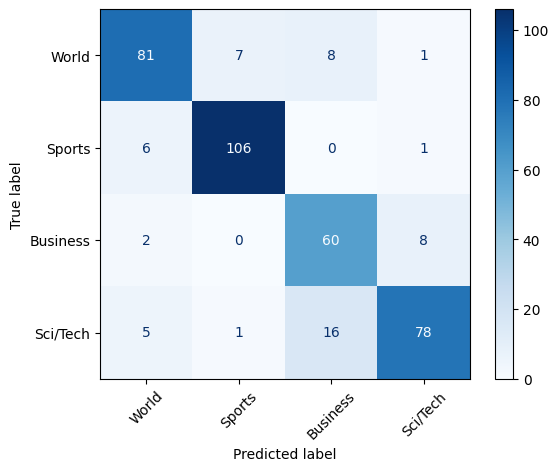

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = test_df_3["true_label"]
y_pred = test_df_3["pred_label"]
labels = ["World", "Sports", "Business", "Sci/Tech"]

cm = confusion_matrix(y_true, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", xticks_rotation=45)
